# 5 - Chart results

Turning all the accessibiltiy results into charts, per scenario and destination. The process is set up for batch production, which imposes higher costs in terms of organization at a benefit of scale. You can of course adapt the code to a simpler approach

Charting in Python always feels inferior to charting in R, my "native" chart habitat (sorry seaborn). Therefore I've used the plotnine library which ports R's ggplot2 library to python. It's important to note that plotnine contains only about 85-90% of ggplot's functionality, so experienced R users may occasionally be confused or disappointed.

It's also worth pointing out that plotnine returns deeply mysterious error messages when you type something incorrectly or just use a parameter it doesn't have (as per above). Budget extra time for troubleshooting.

In [1]:
import pandas as pd
import os, sys
import re

import GOSTnets as gn
import importlib
importlib.reload(gn)
import geopandas as gpd
import rasterio
from rasterio import features
from shapely.wkt import loads
from shapely import wkt
import numpy as np
import pandas as pd

import palettable
from functools import reduce
from pandas.api.types import CategoricalDtype
from plotnine import *

from pprint import pprint

from mizani.formatters import percent_format


## Setup

Set path locations

In [2]:
basepth = r'..'

chart_pth = r'products/charts'
fin_pth = r'final'
input_pth = r'inputs'
net_pth = r'results/200521' # change folder name to date range of last output
table_pth = r'tables'

adm_pth = r'../../../GEO/Boundaries'
geo_pth = r'../../../GEO'


### Load in data

In [ ]:
pckle = r'final_G.pickle'

Tabular data

In [3]:
# Load in tabular data

hrsl_adm = pd.read_csv(os.path.join(geo_pth,'Population/CXB/hrsl_pts_admins.csv'))
demog_upz = pd.read_csv(os.path.join(input_pth,'demog2011_upz.csv'))
wt_demog_upz = pd.read_csv(os.path.join(input_pth,'wt_demog2011_upz.csv'))
econ_union = pd.read_csv(os.path.join(input_pth,'econ_union_clean.csv'))

In [4]:
econ_union.union_code = econ_union.union_code.astype('str')

Processed admin data

In [5]:
adm3 = gpd.read_file(r'results/spatial/adm3_summary.gpkg',driver="GPKG")
adm4 = gpd.read_file(r'results/spatial/adm4_summary.gpkg',driver="GPKG")

In [6]:
# Fix types for later joining
adm4['ADM4_PCODE'] = adm4['ADM4_PCODE'].astype(str)
wt_demog_upz['adm3_code'] = wt_demog_upz['adm3_code'].astype(str)
econ_union['union_code'] = econ_union['union_code'].astype(str)

Processed tabular data

In [7]:

timecats_merged = pd.read_csv(r'results/tables/adm2_time_categories.csv')
timecats_merged_tu = pd.read_csv(r'results/tables/adm2_time_categories_tu.csv')

educ_data = pd.read_csv(r'results/tables/adm2_access_by_educ_level.csv')
econC_empl_data = pd.read_csv(r'results/tables/adm2_access_by_empl_type_EconCensus.csv')
Census_empl_data = pd.read_csv(r'results/tables/adm2_access_by_empl_type_2011Census.csv')

empl_access_upz = pd.read_csv(r'results/tables/adm3_pop_weighted_access_by_empl_type_upz_EconCensus.csv')
empl_access_upz_long = pd.read_csv(r'results/tables/adm3_pop_weighted_access_by_empl_type_upz_EconCensus_LONG.csv')
empl_pc_access_upz_long = pd.read_csv(r'results/tables/adm3_pop_weighted_access_by_empl_type_upz_PopCensus_LONG.csv')
educ_access_upz_long = pd.read_csv(r'results/tables/adm3_pop_weighted_access_by_educ_level_upz_PopCensus_LONG.csv')


#### Define a reference dict that can be looped through for chart generation at scale

This is a crucial, and admittedly tedious step. The dictionary contains values for labeling and displaying different destination / scenario combinations of data at different administrative levels. Setting the break ranges in particular may take some trial and error to correctly scope what looks best. The benefit is that once set, you can loop over the dictionary and create bundles of charts very quickly for any number of administrative units

I recommend preparing this dictionary in a separate text editor like Sublime or Atom, where you can see values more clearly and edit many things at once.

In [8]:
all_scenarios = {\
                'current_cxb' : {'title': 'Cox\'s Bazar',
									'scenario' : '',
                                    'coord_cartes' : [0,150],
                                    'breaks_adm2' : [60,90,10],
                                    'breaks_adm3' : [0,180,30],
                                    'breaks_adm4' : [0,180,30],
									'plot_name' : 'CXB'}, \
                'current_chitt' : {'title': 'Chittagong',
									'scenario' : '',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [120,180,30],
                                    'breaks_adm3' : [0,240,30],
                                    'breaks_adm4' : [0,360,60],
									'plot_name' : 'Chittagong'}, \
                'current_martar' : {'title': 'Martarbari',
									'scenario' : '',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [0,120,30],
                                    'breaks_adm3' : [0,210,30],
                                    'breaks_adm4' : [0,300,30],
									'plot_name' : 'Martarbari'}, \
                'current_health' : {'title': 'healthcare facilities',
									'scenario' : '',
                                    'coord_cartes' : [0,30],
                                    'breaks_adm2' : [0,30,5],
                                    'breaks_adm3' : [0,40,10],
                                    'breaks_adm4' : [0,45,15],
									'plot_name' : 'health'}, \
                'current_primary_ed' : {'title': 'primary schools',
									'scenario' : '',
                                    'coord_cartes' : [0,20],
                                    'breaks_adm2' : [0,10,5],
                                    'breaks_adm3' : [0,15,5],
                                    'breaks_adm4' : [0,20,5],
									'plot_name' : 'primary_education'}, \
                'current_secondary_ed' : {'title': 'secondary schools',
									'scenario' : '',
                                    'coord_cartes' : [0,30],
                                    'breaks_adm2' : [0,20,5],
                                    'breaks_adm3' : [0,30,10],
                                    'breaks_adm4' : [0,40,10],
									'plot_name' : 'secondary_education'}, \
                'current_tertiary_ed' : {'title': 'universities',
									'scenario' : '',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [0,90,15],
                                    'breaks_adm3' : [0,180,30],
                                    'breaks_adm4' : [0,180,30],
									'plot_name' : 'tertiary_education'}, \
                'current_allmkts' : {'title': 'all markets (of any size)',
									'scenario' : '',
                                    'coord_cartes' : [0,60],
                                    'breaks_adm2' : [0,20,5],
                                    'breaks_adm3' : [0,20,5],
                                    'breaks_adm4' : [0,30,10],
									'plot_name' : 'allmkts'}, \
                'current_growthcenters' :  {'title': 'growth centers',
									'scenario' : '',
                                    'coord_cartes' : [0,60],
                                    'breaks_adm2' : [0,30,5],
                                    'breaks_adm3' : [0,30,10],
                                    'breaks_adm4' : [0,60,15],
									'plot_name' : 'growthcenters'}, \

                'ua_cxb' : {'title': 'Cox\'s Bazar',
									'scenario' : 'with CXB ferry and upgrades to key roads',
                                    'coord_cartes' : [0,150],
                                    'breaks_adm2' : [60,90,10],
                                    'breaks_adm3' : [0,180,30],
                                    'breaks_adm4' : [0,180,30],
									'plot_name' : 'CXB'}, \
                'ua_chitt' : {'title': 'Chittagong',
									'scenario' : 'with CXB ferry and upgrades to key roads',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [120,180,30],
                                    'breaks_adm3' : [0,240,30],
                                    'breaks_adm4' : [0,360,60],
									'plot_name' : 'Chittagong'}, \
                'ua_martar' : {'title': 'Martarbari',
									'scenario' : 'with CXB ferry and upgrades to key roads',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [0,120,30],
                                    'breaks_adm3' : [0,210,30],
                                    'breaks_adm4' : [0,300,30],
									'plot_name' : 'Martarbari'}, \
                'ua_health' : {'title': 'healthcare facilities',
									'scenario' : 'with CXB ferry and upgrades to key roads',
                                    'coord_cartes' : [0,30],
                                    'breaks_adm2' : [0,30,5],
                                    'breaks_adm3' : [0,40,10],
                                    'breaks_adm4' : [0,45,15],
									'plot_name' : 'health'}, \
                'ua_primary_ed' : {'title': 'primary schools',
									'scenario' : 'with CXB ferry and upgrades to key roads',
                                    'coord_cartes' : [0,20],
                                    'breaks_adm2' : [0,10,5],
                                    'breaks_adm3' : [0,15,5],
                                    'breaks_adm4' : [0,20,5],
									'plot_name' : 'primary_education'}, \
                'ua_secondary_ed' : {'title': 'secondary schools',
									'scenario' : 'with CXB ferry and upgrades to key roads',
                                    'coord_cartes' : [0,30],
                                    'breaks_adm2' : [0,20,5],
                                    'breaks_adm3' : [0,30,10],
                                    'breaks_adm4' : [0,40,10],
									'plot_name' : 'secondary_education'}, \
                'ua_tertiary_ed' : {'title': 'universities',
									'scenario' : 'with CXB ferry and upgrades to key roads',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [0,90,15],
                                    'breaks_adm3' : [0,180,30],
                                    'breaks_adm4' : [0,180,30],
									'plot_name' : 'tertiary_education'}, \
                'ua_allmkts' : {'title': 'all markets (of any size)',
									'scenario' : 'with CXB ferry and upgrades to key roads',
                                    'coord_cartes' : [0,60],
                                    'breaks_adm2' : [0,20,5],
                                    'breaks_adm3' : [0,20,5],
                                    'breaks_adm4' : [0,30,10],
									'plot_name' : 'allmkts'}, \
                'ua_growthcenters' :  {'title': 'growth centers',
									'scenario' : 'with CXB ferry and upgrades to key roads',
                                    'coord_cartes' : [0,60],
                                    'breaks_adm2' : [0,30,5],
                                    'breaks_adm3' : [0,30,10],
                                    'breaks_adm4' : [0,60,15],
									'plot_name' : 'growthcenters'}, \

                'uns_cxb' : {'title': 'Cox\'s Bazar',
									'scenario' : 'with CXB ferry and upgrades to key northern roads',
                                    'coord_cartes' : [0,150],
                                    'breaks_adm2' : [60,90,10],
                                    'breaks_adm3' : [0,180,30],
                                    'breaks_adm4' : [0,180,30],
									'plot_name' : 'CXB'}, \
                'uns_chitt' : {'title': 'Chittagong',
									'scenario' : 'with CXB ferry and upgrades to key northern roads',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [120,180,30],
                                    'breaks_adm3' : [0,240,30],
                                    'breaks_adm4' : [0,360,60],
									'plot_name' : 'Chittagong'}, \
                'uns_martar' : {'title': 'Martarbari',
									'scenario' : 'with CXB ferry and upgrades to key northern roads',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [0,120,30],
                                    'breaks_adm3' : [0,210,30],
                                    'breaks_adm4' : [0,300,30],
									'plot_name' : 'Martarbari'}, \
                'uns_health' : {'title': 'healthcare facilities',
									'scenario' : 'with CXB ferry and upgrades to key northern roads',
                                    'coord_cartes' : [0,30],
                                    'breaks_adm2' : [0,30,5],
                                    'breaks_adm3' : [0,40,10],
                                    'breaks_adm4' : [0,45,15],
									'plot_name' : 'health'}, \
                'uns_primary_ed' : {'title': 'primary schools',
									'scenario' : 'with CXB ferry and upgrades to key northern roads',
                                    'coord_cartes' : [0,20],
                                    'breaks_adm2' : [0,10,5],
                                    'breaks_adm3' : [0,15,5],
                                    'breaks_adm4' : [0,20,5],
									'plot_name' : 'primary_education'}, \
                'uns_secondary_ed' : {'title': 'secondary schools',
									'scenario' : 'with CXB ferry and upgrades to key northern roads',
                                    'coord_cartes' : [0,30],
                                    'breaks_adm2' : [0,20,5],
                                    'breaks_adm3' : [0,30,10],
                                    'breaks_adm4' : [0,40,10],
									'plot_name' : 'secondary_education'}, \
                'uns_tertiary_ed' : {'title': 'universities',
									'scenario' : 'with CXB ferry and upgrades to key northern roads',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [0,90,15],
                                    'breaks_adm3' : [0,180,30],
                                    'breaks_adm4' : [0,180,30],
									'plot_name' : 'tertiary_education'}, \
                'uns_allmkts' : {'title': 'all markets (of any size)',
									'scenario' : 'with CXB ferry and upgrades to key northern roads',
                                    'coord_cartes' : [0,60],
                                    'breaks_adm2' : [0,20,5],
                                    'breaks_adm3' : [0,20,5],
                                    'breaks_adm4' : [0,30,10],
									'plot_name' : 'allmkts'}, \
                'uns_growthcenters' : {'title': 'growth centers',
									'scenario' : 'with CXB ferry and upgrades to key northern roads',
                                    'coord_cartes' : [0,60],
                                    'breaks_adm2' : [0,30,5],
                                    'breaks_adm3' : [0,30,10],
                                    'breaks_adm4' : [0,60,15],
									'plot_name' : 'growthcenters'},

                'unf_cxb' : {'title': 'Cox\'s Bazar',
									'scenario' : 'with upgrades to key roads',
                                    'coord_cartes' : [0,150],
                                    'breaks_adm2' : [60,90,10],
                                    'breaks_adm3' : [0,180,30],
                                    'breaks_adm4' : [0,180,30],
									'plot_name' : 'CXB'}, \
                'unf_chitt' : {'title': 'Chittagong',
									'scenario' : 'with upgrades to key roads',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [120,180,30],
                                    'breaks_adm3' : [0,240,30],
                                    'breaks_adm4' : [0,360,60],
									'plot_name' : 'Chittagong'}, \
                'unf_martar' : {'title': 'Martarbari',
									'scenario' : 'with upgrades to key roads',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [0,120,30],
                                    'breaks_adm3' : [0,210,30],
                                    'breaks_adm4' : [0,300,30],
									'plot_name' : 'Martarbari'}, \
                'unf_health' : {'title': 'healthcare facilities',
									'scenario' : 'with upgrades to key roads',
                                    'coord_cartes' : [0,30],
                                    'breaks_adm2' : [0,30,5],
                                    'breaks_adm3' : [0,40,10],
                                    'breaks_adm4' : [0,45,15],
									'plot_name' : 'health'}, \
                'unf_primary_ed' : {'title': 'primary schools',
									'scenario' : 'with upgrades to key roads',
                                    'coord_cartes' : [0,20],
                                    'breaks_adm2' : [0,10,5],
                                    'breaks_adm3' : [0,15,5],
                                    'breaks_adm4' : [0,20,5],
									'plot_name' : 'primary_education'}, \
                'unf_secondary_ed' : {'title': 'secondary schools',
									'scenario' : 'with upgrades to key roads',
                                    'coord_cartes' : [0,30],
                                    'breaks_adm2' : [0,20,5],
                                    'breaks_adm3' : [0,30,10],
                                    'breaks_adm4' : [0,40,10],
									'plot_name' : 'secondary_education'}, \
                'unf_tertiary_ed' : {'title': 'universities',
									'scenario' : 'with upgrades to key roads',
                                    'coord_cartes' : [0,180],
                                    'breaks_adm2' : [0,90,15],
                                    'breaks_adm3' : [0,180,30],
                                    'breaks_adm4' : [0,180,30],
									'plot_name' : 'tertiary_education'}, \
                'unf_allmkts' : {'title': 'all markets (of any size)',
									'scenario' : 'with upgrades to key roads',
                                    'coord_cartes' : [0,60],
                                    'breaks_adm2' : [0,20,5],
                                    'breaks_adm3' : [0,20,5],
                                    'breaks_adm4' : [0,30,10],
									'plot_name' : 'allmkts'}, \
                'unf_growthcenters' : {'title': 'growth centers',
									'scenario' : 'with upgrades to key roads',
                                    'coord_cartes' : [0,60],
                                    'breaks_adm2' : [0,30,5],
                                    'breaks_adm3' : [0,30,10],
                                    'breaks_adm4' : [0,60,15],
									'plot_name' : 'growthcenters'} }


## Charting

#### Colors are important, colors are our friends


In [9]:
from pandas.api.types import CategoricalDtype
from plotnine import *

from mizani.formatters import percent_format

## good reference: https://datacarpentry.org/python-ecology-lesson/07-visualization-ggplot-python/index.html

In [10]:
from palettable.wesanderson import FantasticFox2_5
# from palettable.wesanderson import FantasticFox2_5
from palettable.colorbrewer.sequential import BuGn_6
from palettable.wesanderson import IsleOfDogs3_4 # decent
from palettable.cartocolors.sequential import BurgYl_5

In [11]:
FantasticFox2_5.hex_colors

['#E4BF44', '#C65742', '#9AD0BB', '#332737', '#ABA18D']

In [12]:
BurgYl_5.hex_colors

['#FBE6C5', '#EE8A82', '#DC7176', '#C8586C', '#70284A']

In [13]:
TU_comp_colors = ['#fcdaa4','#915133'] # #edddc6 too light

In [14]:
TU_comp_colors

['#fcdaa4', '#915133']

In [15]:
## not necessary, keeping for reference

empl_colors = {'Industrial' : FantasticFox2_5.hex_colors[1], 
                    'Service' : FantasticFox2_5.hex_colors[2], 
                    'Total' : FantasticFox2_5.hex_colors[3] }

empl_colors

{'Industrial': '#C65742', 'Service': '#9AD0BB', 'Total': '#332737'}

Leftover code for finding available fonts

In [16]:
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts()

Ignore warnings from PlotNine

In [17]:
import warnings
warnings.filterwarnings("ignore") # couldn't manage to specify the exact PlotNineWarning

### Adm2 - District-wide
#### Simple averages

##### Percentage time categories plots

Create an ordered variable

In [18]:
# Determine order and create a categorical type
# education_list = educ_access_upz_long['Education level'].value_counts().index.tolist()

timecat_list = ['0 - 15','15 - 30','30 - 45','45 - 60','60 - 75', '75 - 90','90 - 120','120 - 180','180 - 240','240 - 300']
timecat_cat = pd.Categorical(timecats_merged['time_cat'], categories=timecat_list)
timecat_cat_tu = pd.Categorical(timecats_merged_tu['time_cat'], categories=timecat_list)

# assign to a new column in the DataFrame
timecats_merged = timecats_merged.assign(timecat_cat = timecat_cat).rename(columns={'timecat_cat':'Travel time category' })
timecats_merged_tu = timecats_merged_tu.assign(timecat_cat = timecat_cat_tu).rename(columns={'timecat_cat':'Travel time category' })

In [19]:
timecats_merged.head(2)

,Unnamed: 0,time_cat,current_cxb_popn,current_cxb_avg_time,current_cxb_pop_pct,current_chitt_popn,current_chitt_avg_time,current_chitt_pop_pct,current_martar_popn,current_martar_avg_time,...,unf_tertiary_ed_popn,unf_tertiary_ed_avg_time,unf_tertiary_ed_pop_pct,unf_allmkts_popn,unf_allmkts_avg_time,unf_allmkts_pop_pct,unf_growthcenters_popn,unf_growthcenters_avg_time,unf_growthcenters_pop_pct,Travel time category
0,0,0 - 15,260816,7.786524,0.100017,0,NaN,0.0,30021,10.616797,...,7464,11.429357,0.002862,1865057,8.433703,0.715209,1314344,8.764055,0.504023,0 - 15
1,1,15 - 30,195486,23.066656,0.074965,0,NaN,0.0,89712,22.929840,...,70817,24.825084,0.027157,630587,20.121587,0.241817,825297,21.425728,0.316484,15 - 30


In [20]:
timecats_merged_tu.head(2)

,Unnamed: 0,TU,time_cat,current_cxb_popn,current_cxb_avg_time,tu_pop_x,current_cxb_pop_pct,current_chitt_popn,current_chitt_avg_time,tu_pop_y,...,unf_allmkts_popn,unf_allmkts_avg_time,tu_pop_x.17,unf_allmkts_pop_pct,unf_growthcenters_popn,unf_growthcenters_avg_time,tu_pop_y.17,unf_growthcenters_pop_pct,time_cat_label,Travel time category
0,0,Other,0 - 15,260816,7.786524,2.069835e+06,0.126008,0,NaN,NaN,...,1411074,8.415461,2.069835e+06,0.681733,925304,8.606717,2.069835e+06,0.447042,0 - 15,0 - 15
1,1,Other,15 - 30,195051,23.051096,2.069835e+06,0.094235,0,NaN,NaN,...,551625,20.180486,2.069835e+06,0.266507,693973,21.682361,2.069835e+06,0.335279,15 - 30,15 - 30


Create the charts

In [21]:
for key, val in all_scenarios.items():
    
#     print(key)

    ylim1 = val['coord_cartes'][0]
    ylim2 = val['coord_cartes'][1]
    
    break1 = val['breaks_adm2'][0]
    break2 = val['breaks_adm2'][1]
    break3 = val['breaks_adm2'][2]
        
    adm2_timecat_pct_plot = (ggplot(timecats_merged)         # defining what data to use
     + aes(x='Travel time category',y='{}_pop_pct'.format(key))    # defining what variable to use
     + geom_bar(size=16,stat="identity",fill = "#FF6666") # defining the type of plot to use
     + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]) # lambda for making % labels
    #  + scale_y_continuous(labels=percent_format()) # alternate method
    #  + theme(axis_text_y = element_text(angle = 45)) # not necessary with coord_flip
     + theme(panel_background = element_rect(fill = "#EDEDED"),
            panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = '#C9C9C9'),
            panel_grid_major_y = element_blank(),
            panel_grid_minor = element_blank(),
            panel_border = element_blank(),
            axis_line = element_line(colour = '#7f7f7f'),
            axis_title = element_text(colour = '#4C4C4C',size=10.5),
            axis_text_x = element_text(colour = '#7f7f7f'),
            axis_text_y = element_text(colour = '#7f7f7f'),
            axis_ticks = element_blank(),
            text = element_text(family='Proxima Nova',weight='bold'),
            legend_text = element_text(weight='normal'),
            legend_background = element_blank(),
            legend_box_margin=22.5,
            legend_title_align = 'center',
            legend_title = element_text(color='#4C4C4C'),
            legend_position = 'bottom')
     + labs(title='Travel time to {}\n{}'.format(val['title'],val['scenario']),\
            subtitle='Extrapolated from HRSL population models', \
            x='Minutes to {}'.format(val['title']), \
            y='District population share')
     + coord_flip()
    )

    ggsave(plot = adm2_timecat_pct_plot, filename = 'adm2_{}_timecat_pct_plot'.format(key), path = chart_pth, dpi = 450)


##### Population totals time categories plots

In [22]:
for key, val in all_scenarios.items():
    
#     print(key)

    ylim1 = val['coord_cartes'][0]
    ylim2 = val['coord_cartes'][1]
    
    break1 = val['breaks_adm2'][0]
    break2 = val['breaks_adm2'][1]
    break3 = val['breaks_adm2'][2]
        
    adm2_timecat_popn_plot = (ggplot(timecats_merged)         # defining what data to use
     + aes(x='Travel time category',y='{}_popn'.format(key))    # defining what variable to use
     + geom_bar(size=16,stat="identity",fill = "#FF6666") # defining the type of plot to use            
     + theme(panel_background = element_rect(fill = "#EDEDED"),
            panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = '#C9C9C9'),
            panel_grid_major_y = element_blank(),
            panel_grid_minor = element_blank(),
            panel_border = element_blank(),
            axis_line = element_line(colour = '#7f7f7f'),
            axis_title = element_text(colour = '#4C4C4C',size=10.5),
            axis_text_x = element_text(colour = '#7f7f7f'),
            axis_text_y = element_text(colour = '#7f7f7f'),
            axis_ticks = element_blank(),
            text = element_text(family='Proxima Nova',weight='bold'),
            legend_text = element_text(weight='normal'),
            legend_background = element_blank(),
            legend_box_margin=22.5,
            legend_title_align = 'center',
            legend_title = element_text(color='#4C4C4C'),
            legend_position = 'bottom')
     + labs(title='Travel time to {}\n{}'.format(val['title'],val['scenario']),\
            subtitle='Extrapolated from HRSL population models', \
            x='Minutes to {}'.format(val['title']), \
            y='Population')
     + coord_flip()
     + scale_y_continuous(label='comma')  
    )

    ggsave(plot = adm2_timecat_popn_plot, filename = 'adm2_{}_timecat_popn_plot'.format(key), path = chart_pth, dpi = 450)


#### Teknaf/Ukhia Comparisons

Repeated but comparing Teknaf and Ukhia to other Upazilas

In [23]:
TU_comp_colors

['#fcdaa4', '#915133']

In [24]:
for key, val in all_scenarios.items():
    
#     print(key)

    ylim1 = val['coord_cartes'][0]
    ylim2 = val['coord_cartes'][1]
    
    break1 = val['breaks_adm2'][0]
    break2 = val['breaks_adm2'][1]
    break3 = val['breaks_adm2'][2]
        
    adm2_timecat_pct_plot = (ggplot(timecats_merged_tu)         # defining what data to use
     + aes(x='Travel time category',y='{}_pop_pct'.format(key),fill='TU')    # defining what variable to use
     + geom_bar(size=16,stat="identity",position="dodge") # defining the type of plot to use
     + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]) # lambda for making % labels
    #  + scale_y_continuous(labels=percent_format()) # alternate method
    #  + theme(axis_text_y = element_text(angle = 45)) # not necessary with coord_flip
     + theme(panel_background = element_rect(fill = "#fbfbfb"),
            panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = '#C9C9C9'),
            panel_grid_major_y = element_blank(),
            panel_grid_minor = element_blank(),
            panel_border = element_blank(),
            axis_line = element_line(colour = '#7f7f7f'),
            axis_title = element_text(colour = '#4C4C4C',size=10.5),
            axis_text_x = element_text(colour = '#7f7f7f'),
            axis_text_y = element_text(colour = '#7f7f7f'),
            axis_ticks = element_blank(),
            text = element_text(family='Proxima Nova',weight='bold'),
            legend_text = element_text(weight='normal'),
            legend_background = element_blank(),
            legend_box_margin=22.5,
            legend_title_align = 'center',
            legend_title = element_text(color='#4C4C4C'),
            legend_position = 'bottom')
     + labs(title='Travel time to {}\n{}'.format(val['title'],val['scenario']),\
            subtitle='Extrapolated from HRSL population models', \
            x='Minutes to {}'.format(val['title']), \
            y='District population share')
     + scale_fill_manual(values=TU_comp_colors,name='Upazilas') # legend title here
     + coord_flip()
    )

    ggsave(plot = adm2_timecat_pct_plot, filename = 'adm2_{}_tu_timecat_pct_plot'.format(key), path = chart_pth, dpi = 450)


##### Population totals time categories plots

In [25]:
for key, val in all_scenarios.items():
    
#     print(key)

    ylim1 = val['coord_cartes'][0]
    ylim2 = val['coord_cartes'][1]
    
    break1 = val['breaks_adm2'][0]
    break2 = val['breaks_adm2'][1]
    break3 = val['breaks_adm2'][2]
        
    adm2_timecat_popn_plot = (ggplot(timecats_merged_tu)         # defining what data to use
     + aes(x='Travel time category',y='{}_popn'.format(key), fill='TU')    # defining what variable to use
     + geom_bar(size=16,stat="identity",position="dodge") # defining the type of plot to use            
     + theme(panel_background = element_rect(fill = "#fbfbfb"),
            panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = '#C9C9C9'),
            panel_grid_major_y = element_blank(),
            panel_grid_minor = element_blank(),
            panel_border = element_blank(),
            axis_line = element_line(colour = '#7f7f7f'),
            axis_title = element_text(colour = '#4C4C4C',size=10.5),
            axis_text_x = element_text(colour = '#7f7f7f'),
            axis_text_y = element_text(colour = '#7f7f7f'),
            axis_ticks = element_blank(),
            text = element_text(family='Proxima Nova',weight='bold'),
            legend_text = element_text(weight='normal'),
            legend_background = element_blank(),
            legend_box_margin=22.5,
            legend_title_align = 'center',
            legend_title = element_text(color='#4C4C4C'),
            legend_position = 'bottom')
     + labs(title='Travel time to {}\n{}'.format(val['title'],val['scenario']),\
            subtitle='Extrapolated from HRSL population models', \
            x='Minutes to {}'.format(val['title']), \
            y='Population')
     + coord_flip()
     + scale_fill_manual(values=TU_comp_colors,name='Upazilas') # legend title here
     + scale_y_continuous(label='comma')  
    )

    ggsave(plot = adm2_timecat_popn_plot, filename = 'adm2_{}_tu_timecat_popn_plot'.format(key), path = chart_pth, dpi = 450)


#### Breakdowns by education and employment level

In [26]:
educ_data

,Unnamed: 0,Education level,current_cxb_avg_time,current_chitt_avg_time,current_martar_avg_time,current_health_avg_time,current_primary_ed_avg_time,current_secondary_ed_avg_time,current_tertiary_ed_avg_time,current_allmkts_avg_time,...,uns_growthcenters_avg_time,unf_cxb_avg_time,unf_chitt_avg_time,unf_martar_avg_time,unf_health_avg_time,unf_primary_ed_avg_time,unf_secondary_ed_avg_time,unf_tertiary_ed_avg_time,unf_allmkts_avg_time,unf_growthcenters_avg_time
0,0,No education,81.584066,163.614367,110.853835,21.622942,9.263438,15.047438,92.150188,12.632496,...,19.996841,78.110177,160.765616,89.842890,20.976082,9.231906,14.901543,88.663290,12.512195,19.997997
1,1,Primary,77.748027,156.435781,109.134112,21.084234,8.866360,15.197866,87.282769,12.615369,...,19.357196,75.131508,154.454972,87.192253,20.508744,8.846047,15.084462,84.659582,12.530021,19.358306
2,2,Lower Secondary,74.178851,151.494891,101.919094,21.390018,8.500309,14.717662,83.557875,12.408179,...,19.015635,71.209681,149.140222,80.196266,20.748852,8.473996,14.585330,80.581106,12.306027,19.017117
3,3,Secondary,70.089948,151.797883,104.201249,19.499466,8.101776,13.942996,80.812615,11.683841,...,17.566606,67.547055,149.796725,82.082442,18.960870,8.078648,13.826344,78.265150,11.594775,17.567819
4,4,Higher Secondary,65.975348,151.826891,105.959405,18.212090,7.788637,13.352116,77.789903,11.136767,...,16.540733,63.846601,150.127671,83.409088,17.761803,7.771125,13.259139,75.655636,11.066613,16.541969
5,5,University,65.127710,151.930280,105.889508,17.867245,7.507170,12.982660,77.381650,10.829348,...,15.937595,62.986627,150.180405,83.331562,17.409494,7.490611,12.897397,75.234765,10.764994,15.938660


In [27]:
econC_empl_data

,Unnamed: 0,Employment type,current_cxb_avg_time,current_chitt_avg_time,current_martar_avg_time,current_health_avg_time,current_primary_ed_avg_time,current_secondary_ed_avg_time,current_tertiary_ed_avg_time,current_allmkts_avg_time,...,uns_growthcenters_avg_time,unf_cxb_avg_time,unf_chitt_avg_time,unf_martar_avg_time,unf_health_avg_time,unf_primary_ed_avg_time,unf_secondary_ed_avg_time,unf_tertiary_ed_avg_time,unf_allmkts_avg_time,unf_growthcenters_avg_time
0,0,Industrial,69.721833,144.236295,100.714838,20.500267,7.606833,13.696061,78.083010,11.359396,...,17.940878,68.194480,142.776440,77.436775,20.107418,7.597471,13.648367,76.519802,11.316069,17.941299
1,1,Service,66.705941,159.301499,115.251938,15.674706,7.976430,13.276603,80.511624,9.745408,...,14.953994,65.317155,157.743778,91.810320,15.389925,7.960752,13.216936,79.102828,9.690076,14.954640


In [28]:
Census_empl_data

,Unnamed: 0,Employment type,current_cxb_avg_time,current_chitt_avg_time,current_martar_avg_time,current_health_avg_time,current_primary_ed_avg_time,current_secondary_ed_avg_time,current_tertiary_ed_avg_time,current_allmkts_avg_time,...,uns_growthcenters_avg_time,unf_cxb_avg_time,unf_chitt_avg_time,unf_martar_avg_time,unf_health_avg_time,unf_primary_ed_avg_time,unf_secondary_ed_avg_time,unf_tertiary_ed_avg_time,unf_allmkts_avg_time,unf_growthcenters_avg_time
0,0,Agricultural,82.251060,156.881943,106.007687,22.432238,8.685197,15.040111,92.773621,12.723294,...,20.095527,79.678146,153.744618,83.582775,21.921646,8.665628,14.950061,90.144212,12.643821,20.095968
1,1,Industrial,66.739518,158.811115,115.729587,16.781632,8.201360,14.321774,78.680341,11.046491,...,16.268702,65.912632,157.167901,91.573172,16.578395,8.189666,14.273519,77.839397,11.004644,16.269337
2,2,Service,57.413600,153.669769,111.257671,14.831436,6.759978,12.222028,72.530404,9.403624,...,13.617041,56.430862,152.348516,87.504248,14.629257,6.748042,12.177349,71.538165,9.364192,13.618939


##### Breakdowns by education level

In [29]:
# Determine order and create a categorical type
# Note that value_counts() is already sorted
# education_list = educ_data['Education level'].value_counts().index.tolist()

education_list = ['No education', 'Primary', 'Lower Secondary', 'Secondary', 'Higher Secondary', 'University']
education_cat = pd.Categorical(educ_data['Education level'], categories=education_list)

# assign to a new column in the DataFrame
educ_data = educ_data.assign(education_cat = education_cat)

In [30]:
for key, val in all_scenarios.items():
    
#     print(key) # for troubleshooting
    
    ylim1 = val['coord_cartes'][0]
    ylim2 = val['coord_cartes'][1]
    
    break1 = val['breaks_adm2'][0]
    break2 = val['breaks_adm2'][1]
    break3 = val['breaks_adm2'][2]
    
    adm2_educ_plot = (ggplot(educ_data)         
     + aes(x='education_cat',y='{}_avg_time'.format(key)) 
     + geom_bar(width=.6,stat="identity",fill = "#ce78b3") 
     + scale_y_continuous(breaks=range(break1,break2,break3))
     + scale_fill_manual(values=BuGn_6.hex_colors)
     + theme(panel_background = element_rect(fill = "#EDEDED"),
            panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = '#C9C9C9'),
            panel_grid_major_y = element_blank(),
            panel_grid_minor = element_blank(),
            panel_border = element_blank(),
            axis_line = element_line(colour = '#7f7f7f'),
            axis_title = element_text(colour = '#4C4C4C',size=10.5),
            axis_text_x = element_text(colour = '#7f7f7f'),
            axis_text_y = element_text(colour = '#7f7f7f'),
            axis_ticks = element_blank(),
            text = element_text(family='Proxima Nova',weight='bold'),
            legend_text = element_text(weight='normal'),
            legend_background = element_blank(),
            legend_box_margin=22.5,
            legend_title_align = 'center',
            legend_title = element_text(color='#4C4C4C'),
            legend_position = 'bottom')
     + labs(title='Average travel times to {}\nby level of education {}'.format(val['title'],val['scenario']), \
            subtitle='Extraploted from 2011 census',\
            x='Education Level', \
            y='Minutes travel to {}'.format(val['title']) ) 
     + coord_flip(ylim=(break1,break2))
            )

    ggsave(plot = adm2_educ_plot, filename = 'adm2_educ_{}_plot'.format(key), path = chart_pth, dpi = 450)


##### Breakdowns by employment - 2013 econ census

Commented out as we ended up using only the 2011 population census versions of this

In [31]:
# for key, val in all_scenarios.items():
    
# #     print(key)
    
#     ylim1 = val['coord_cartes'][0]
#     ylim2 = val['coord_cartes'][1]
    
#     break1 = val['breaks_adm2'][0]
#     break2 = val['breaks_adm2'][1]
#     break3 = val['breaks_adm2'][2]
    
#     adm2_empl_econ_census_plot = (ggplot(econC_empl_data)         
#      + aes(x='Employment type',y='{}_avg_time'.format(key),fill='Employment type') 
#      + geom_bar(width=.6,stat="identity") \
#      + coord_cartesian(ylim=(ylim1,ylim2)) 
#      + scale_y_continuous(breaks=range(break1,break2,break3)) 
#      + scale_fill_manual(values=FantasticFox2_5.hex_colors)
#      + theme(panel_background = element_rect(fill = "#EDEDED"),
#             panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = '#C9C9C9'),
#             panel_grid_major_y = element_blank(),
#             panel_grid_minor = element_blank(),
#             panel_border = element_blank(),
#             axis_line = element_line(colour = '#7f7f7f'),
#             axis_title = element_text(colour = '#4C4C4C',size=10.5),
#             axis_text_x = element_text(colour = '#7f7f7f'),
#             axis_text_y = element_text(colour = '#7f7f7f'),
#             axis_ticks = element_blank(),
#             text = element_text(family='Proxima Nova',weight='bold'),
#             legend_text = element_text(weight='normal'),
#             legend_background = element_blank(),
#             legend_box_margin=22.5,
#             legend_title_align = 'center',
#             legend_title = element_text(color='#4C4C4C'),
#             legend_position = 'bottom')
#      + labs(title='Average travel times to {}\nby type of employment {}'.format(val['title'],val['scenario']), \
#             subtitle='Extraploted from economic census',\
#             x='Type of employment', \
#             y='Minutes travel to {}'.format(val['title']) ) 
#             )

#     ggsave(plot = adm2_empl_econ_census_plot, filename = 'adm2_empl_econ_census_{}_plot'.format(key), path = chart_pth, dpi = 450)

# #     ### EMPLOYMENT

# # ggsave(plot = adm2_empl_econ_census_cxb_plot, filename = 'adm2_empl_econ_census_cxb_plot', path = chart_pth, dpi = 450)

# # adm2_empl_econ_census_cxb_plot = (ggplot(econC_empl_data)         # defining what data to use
# #  + aes(x='Employment type',y='current_cxb_avg_time',fill='Employment type')    # defining what variable to use
# #  + geom_bar(width=.6,stat="identity") # defining the type of plot to use
# #  + coord_cartesian(ylim=(60,120))
# #  + scale_y_continuous(breaks=range(60,130,10))
# #  + scale_fill_manual(values=FantasticFox2_5.hex_colors)
# #  + labs(title='Average travel times to Cox\'s Bazaar by type of employment', subtitle='Extraploted from economic census', x='Employment type', y='Minutes travel to Cox\'s Bazaar')
# # )


##### Breakdowns by employment type (from 2011 census)

In [32]:
for key, val in all_scenarios.items():
    
#     print(key)
    
    ylim1 = val['coord_cartes'][0]
    ylim2 = val['coord_cartes'][1]
    
    break1 = val['breaks_adm2'][0]
    break2 = val['breaks_adm2'][1]
    break3 = val['breaks_adm2'][2]
    
    adm2_empl_pop_census_plot = (ggplot(Census_empl_data)         
     + aes(x='Employment type',y='{}_avg_time'.format(key),fill='Employment type') 
     + geom_bar(width=.6,stat="identity") \
#      + coord_cartesian(ylim=(ylim1,ylim2)) 
     + scale_y_continuous(breaks=range(break1,break2,break3)) 
     + scale_fill_manual(values=FantasticFox2_5.hex_colors)
     + theme(panel_background = element_rect(fill = "#EDEDED"),
            panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = '#C9C9C9'),
            panel_grid_major_x = element_blank(),
            panel_grid_minor = element_blank(),
            panel_border = element_blank(),
            axis_line = element_line(colour = '#7f7f7f'),
            axis_title = element_text(colour = '#4C4C4C',size=10.5),
            axis_text_x = element_text(colour = '#7f7f7f'),
            axis_text_y = element_text(colour = '#7f7f7f'),
            axis_ticks = element_blank(),
            text = element_text(family='Proxima Nova',weight='bold'),
            legend_text = element_text(weight='normal'),
            legend_background = element_blank(),
            legend_box_margin=22.5,
            legend_title_align = 'center',
            legend_title = element_text(color='#4C4C4C'),
            legend_position = 'bottom')
     + labs(title='Average travel times to {}\nby type of employment {}'.format(val['title'],val['scenario']), \
            subtitle='Extraploted from population census',\
            x='Type of employment', \
            y='Minutes travel to {}'.format(val['title']) ) 
            )

    ggsave(plot = adm2_empl_pop_census_plot, filename = 'adm2_empl_pop_census_{}_plot'.format(key), path = chart_pth, dpi = 450)


### Adm3 - Upazila 
#### Simple averages

In [33]:
adm3

,Shape_Leng,Shape_Area,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,...,unf_chitt_avg_time,unf_martar_avg_time,unf_health_avg_time,unf_primary_ed_avg_time,unf_secondary_ed_avg_time,unf_tertiary_ed_avg_time,unf_allmkts_avg_time,unf_growthcenters_avg_time,pop,geometry
0,2.059668,0.041748,Chakaria,202216,None,None,None,Cox's Bazar,2022,Chittagong,...,119.328294,52.099281,24.941796,10.462001,20.618629,78.823669,16.641357,22.977016,500245.442848,"POLYGON ((92.05888 21.91832, 92.05894 21.91815..."
1,1.136750,0.018287,Cox'S Bazar Sadar,202224,Coxs Bazar Sadar,None,None,Cox's Bazar,2022,Chittagong,...,146.590184,82.891156,13.658859,5.485427,11.210765,42.911907,7.793667,11.761336,525311.120382,"POLYGON ((92.03514 21.61279, 92.03540 21.61274..."
2,0.466129,0.006257,Kutubdia,202245,None,None,None,Cox's Bazar,2022,Chittagong,...,140.537482,108.451451,19.882700,5.819542,13.248152,157.230470,12.087915,16.588446,145609.528353,"POLYGON ((91.87017 21.92309, 91.87059 21.92302..."
3,1.772102,0.027243,Maheshkhali,202249,None,None,None,Cox's Bazar,2022,Chittagong,...,152.883025,38.595107,33.136757,11.256472,13.143262,111.896019,13.639003,28.576153,364908.719146,"MULTIPOLYGON (((91.97142 21.50223, 91.96927 21..."
4,0.769857,0.011962,Pekua,202256,None,None,None,Cox's Bazar,2022,Chittagong,...,116.826859,55.388779,33.492898,9.640482,15.919394,111.312843,14.694616,32.088693,226572.452344,"POLYGON ((91.97271 21.90432, 91.97291 21.90427..."
5,1.575680,0.033778,Ramu,202266,None,None,None,Cox's Bazar,2022,Chittagong,...,167.659761,104.191347,16.218345,8.563465,12.274974,57.639261,13.656416,15.575828,307187.926968,"POLYGON ((92.16468 21.60561, 92.16502 21.60560..."
6,1.376304,0.027536,Teknaf,202290,None,None,None,Cox's Bazar,2022,Chittagong,...,241.218070,177.749655,11.299215,11.525211,16.114938,124.187025,9.849405,16.723437,302245.653592,"MULTIPOLYGON (((92.32719 20.63543, 92.32749 20..."
7,1.012888,0.022567,Ukhia,202294,None,None,None,Cox's Bazar,2022,Chittagong,...,186.463664,122.995249,13.061883,7.745270,14.107976,69.333981,11.062206,12.742986,235628.130767,"POLYGON ((92.14618 21.34873, 92.14622 21.34853..."


In [34]:
for key, val in all_scenarios.items():
    
#     print(key)

    ylim1 = val['coord_cartes'][0]
    ylim2 = val['coord_cartes'][1]
    
    break1 = val['breaks_adm3'][0]
    break2 = val['breaks_adm3'][1]
    break3 = val['breaks_adm3'][2]

    adm3_plot = (ggplot(adm3)         # defining what data to use
     + aes(x=str.title('Upazila_Name'),y='{}_avg_time'.format(key))    # defining what variable to use
     + geom_bar(width=.6,position="dodge",stat="identity",fill="#7398a1") # defining the type of plot to use
     + labs(title='Average travel times to {}'.format(val['title']),\
            subtitle='Upazila', \
            x='Upazila', \
            y='Minutes travel to {}\n{}'.format(val['title'],val['scenario']) )
     + theme(panel_background = element_rect(fill = "#EDEDED"),
            panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = '#C9C9C9'),
            panel_grid_major_y = element_blank(),
            panel_grid_minor = element_blank(),
            panel_border = element_blank(),
            axis_line = element_line(colour = '#7f7f7f'),
            axis_title = element_text(colour = '#4C4C4C',size=10.5),
            axis_text_x = element_text(colour = '#7f7f7f'),
            axis_text_y = element_text(colour = '#7f7f7f'),
            axis_ticks = element_blank(),
            text = element_text(family='Proxima Nova',weight='bold'),
            legend_text = element_text(weight='normal'),
            legend_background = element_blank(),
            legend_box_margin=22.5,
            legend_title_align = 'center',
            legend_title = element_text(color='#4C4C4C'),
            legend_position = 'bottom')
     + coord_flip(ylim=(break1,break2))
     + scale_y_continuous(breaks=range(break1,break2,break3)) 
                      )
    ggsave(plot = adm3_plot, filename = 'adm3_{}_plot'.format(key), path = chart_pth, dpi = 450)

#### Employment access

In [35]:
empl_access_upz_long['Employment category'].unique()

array(['Total', 'Industry', 'Service'], dtype=object)

In [36]:
empl_access_upz_long['scen_dest'].unique()

array(['current_cxb', 'current_chitt', 'current_martar', 'current_health',
       'current_primary_ed', 'current_secondary_ed',
       'current_tertiary_ed', 'current_allmkts', 'current_growthcenters',
       'ua_cxb', 'ua_chitt', 'ua_martar', 'ua_health', 'ua_primary_ed',
       'ua_secondary_ed', 'ua_tertiary_ed', 'ua_allmkts',
       'ua_growthcenters', 'uns_cxb', 'uns_chitt', 'uns_martar',
       'uns_health', 'uns_primary_ed', 'uns_secondary_ed',
       'uns_tertiary_ed', 'uns_allmkts', 'uns_growthcenters', 'unf_cxb',
       'unf_chitt', 'unf_martar', 'unf_health', 'unf_primary_ed',
       'unf_secondary_ed', 'unf_tertiary_ed', 'unf_allmkts',
       'unf_growthcenters'], dtype=object)

In [37]:
for key, val in all_scenarios.items():
    
#     print(key)

    ylim1 = val['coord_cartes'][0]
    ylim2 = val['coord_cartes'][1]
    
    break1 = val['breaks_adm3'][0]
    break2 = val['breaks_adm3'][1]
    break3 = val['breaks_adm3'][2]
    
    data = empl_pc_access_upz_long[empl_pc_access_upz_long['scen_dest'] == key]

    empl_access = (ggplot(data)         # defining what data to use
     + aes(x='ADM3_EN',y='access_time'.format(key),fill="Employment category")    # defining what variable to use
     + geom_bar(width=.6,position="dodge",stat="identity",) # defining the type of plot to use
     + labs(title='Average travel times to {}\nby type of employment {}'.format(val['title'],val['scenario']), \
            subtitle='Upazila', \
            x='Upazila', \
            y='Minutes travel to {}'.format(val['title']))
     + theme(panel_background = element_rect(fill = "#EDEDED"),
            panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = '#C9C9C9'),
            panel_grid_major_y = element_blank(),
            panel_grid_minor = element_blank(),
            panel_border = element_blank(),
            axis_line = element_line(colour = '#7f7f7f'),
            axis_title = element_text(colour = '#4C4C4C',size=10.5),
            axis_text_x = element_text(colour = '#7f7f7f'),
            axis_text_y = element_text(colour = '#7f7f7f'),
            axis_ticks = element_blank(),
            text = element_text(family='Proxima Nova',weight='bold'),
            legend_text = element_text(weight='normal'),
            legend_background = element_blank(),
            legend_box_margin=22.5,
            legend_title_align = 'center',
            legend_title = element_text(color='#4C4C4C'),
            legend_position = 'bottom')
     + coord_flip(ylim=(break1,break2))
     + scale_y_continuous(breaks=range(break1,break2,break3))
     + scale_fill_manual(values=FantasticFox2_5.hex_colors)
                      )

    ggsave(plot = empl_access, filename = 'adm3_empl_EconCensus_{}_plot'.format(key), path = chart_pth, dpi = 450)


#### Educational level access

In [38]:
educ_access_upz_long.head(2)

,Unnamed: 0,ADM3_EN,ADM3_PCODE,Education level,access_time,scen_dest
0,0,Chakaria,202216,No education,80.277132,current_cxb
1,1,Cox's Bazar Sadar,202224,No education,24.392905,current_cxb


re-ordering education levels for logical chart order

In [39]:
# Determine order and create a categorical type
# Note that value_counts() is already sorted
# education_list = educ_access_upz_long['Education level'].value_counts().index.tolist()

education_list = ['No education', 'Primary', 'Lower Secondary', 'Secondary', 'Higher Secondary', 'University']
education_cat = pd.Categorical(educ_access_upz_long['Education level'], categories=education_list)

# assign to a new column in the DataFrame
educ_access_upz_long = educ_access_upz_long.assign(education_cat = education_cat).rename(columns={'education_cat':'Education lvl' })

In [40]:
educ_access_upz_long.head(2)

,Unnamed: 0,ADM3_EN,ADM3_PCODE,Education level,access_time,scen_dest,Education lvl
0,0,Chakaria,202216,No education,80.277132,current_cxb,No education
1,1,Cox's Bazar Sadar,202224,No education,24.392905,current_cxb,No education


Making the education charts

In [41]:
for key, val in all_scenarios.items():
    
#     print(key)

    ylim1 = val['coord_cartes'][0]
    ylim2 = val['coord_cartes'][1]
    
    break1 = val['breaks_adm3'][0]
    break2 = val['breaks_adm3'][1]
    break3 = val['breaks_adm3'][2]
    
    data = educ_access_upz_long[educ_access_upz_long['scen_dest'] == key]

    educ_access = (ggplot(data)         # defining what data to use
     + aes(x='ADM3_EN',y='access_time'.format(key),fill="Education lvl")    # defining what variable to use
     + geom_bar(width=.6,position="dodge",stat="identity",) # defining the type of plot to use
     + labs(title='Average travel times to {}\nby level of education {}'.format(val['title'],val['scenario']), \
            subtitle='Upazila', \
            x='Upazila', \
            y='Minutes travel to {}'.format(val['title']))
     + theme(panel_background = element_rect(fill = "#EDEDED"),
            panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = '#C9C9C9'),
            panel_grid_major_y = element_blank(),
            panel_grid_minor = element_blank(),
            panel_border = element_blank(),
            axis_line = element_line(colour = '#7f7f7f'),
            axis_title = element_text(colour = '#4C4C4C',size=10.5),
            axis_text_x = element_text(colour = '#7f7f7f'),
            axis_text_y = element_text(colour = '#7f7f7f'),
            axis_ticks = element_blank(),
            text = element_text(family='Proxima Nova',weight='bold'),
            legend_text = element_text(weight='normal'),
            legend_background = element_blank(),
            legend_box_margin=22.5,
            legend_title_align = 'center',
            legend_title = element_text(color='#4C4C4C'),
            legend_position = 'bottom')
     + coord_flip(ylim=(break1,break2))
     + scale_y_continuous(breaks=range(break1,break2,break3))
     + scale_fill_manual(values=BuGn_6.hex_colors,name='Education level') # legend title here
                      )

    ggsave(plot = educ_access, filename = 'adm3_educ_PopCensus_{}_plot'.format(key), path = chart_pth, dpi = 450)


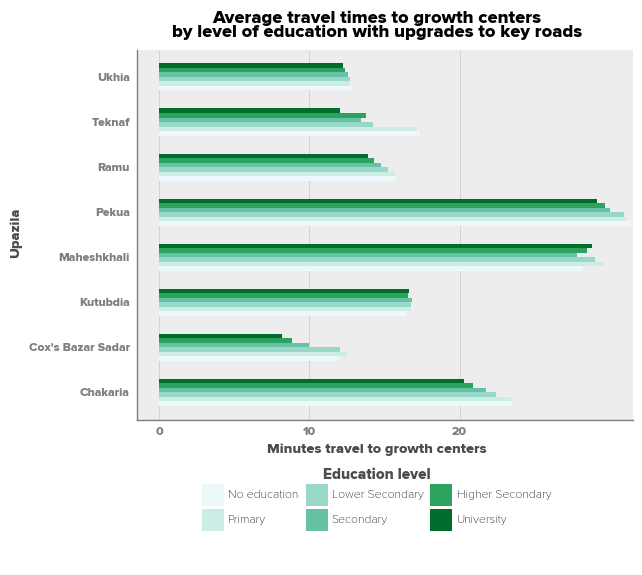

<ggplot: (179469753043)>

In [42]:
educ_access

### Adm4 - Union comparisons

In [43]:
adm4.head(2)

,Shape_Leng,Shape_Area,ADM4_EN,ADM4_PCODE,ADM4_REF,ADM4ALT1EN,ADM4ALT2EN,ADM3_EN,ADM3_PCODE,ADM2_EN,...,unf_allmkts_avg_pc_secon_wt,unf_allmkts_avg_pc_high_secon_wt,unf_allmkts_avg_pc_uni_wt,unf_growthcenters_avg_pc_none_wt,unf_growthcenters_avg_pc_prim_wt,unf_growthcenters_avg_pc_low_secon_wt,unf_growthcenters_avg_pc_secon_wt,unf_growthcenters_avg_pc_high_secon_wt,unf_growthcenters_avg_pc_uni_wt,geometry
0,0.216665,0.001496,Ali Akbar Deil,20224513,None,None,None,Kutubdia,202245,Cox's Bazar,...,1.385953,1.361380,1.288718,3.743966,3.011428,3.047623,2.762322,2.713346,2.568525,"POLYGON ((91.86643 21.78825, 91.86500 21.78487..."
1,0.257282,0.001881,Badarkhali,20221610,None,None,None,Chakaria,202216,Cox's Bazar,...,1.138265,1.014411,1.037145,1.311388,1.165934,1.077016,1.337002,1.191523,1.218226,"POLYGON ((91.96287 21.75378, 91.96279 21.75337..."


In [44]:
for key, val in all_scenarios.items():
    
    adm4 = adm4[adm4['ADM4_EN'] != 'St.Martin Dwip']
    
#     print(key)

    ylim1 = val['coord_cartes'][0]
    ylim2 = val['coord_cartes'][1]
    
    break1 = val['breaks_adm4'][0]
    break2 = val['breaks_adm4'][1]
    break3 = val['breaks_adm4'][2]

    adm4_plot = (ggplot(adm4)         # defining what data to use
     + aes(x='ADM4_EN',y='{}_avg_time'.format(key))    # defining what variable to use
     + geom_bar(width=.6,position="dodge",stat="identity",fill="#7398a1") # defining the type of plot to use
     + labs(title='Average travel times to {}\n{}'.format(val['title'],val['scenario']),\
            subtitle='Union', \
            x='Union', \
            y='Minutes travel to {}\n{}'.format(val['title'],val['scenario']) )
     + theme(panel_background = element_rect(fill = "#EDEDED"),
            panel_grid_major = element_line(size = 0.5, linetype = 'solid', colour = '#C9C9C9'),
            panel_grid_major_y = element_blank(),
            panel_grid_minor = element_blank(),
            panel_border = element_blank(),
            axis_line = element_line(colour = '#7f7f7f'),
            axis_title = element_text(colour = '#4C4C4C',size=10.5),
            axis_text_x = element_text(colour = '#7f7f7f'),
            axis_text_y = element_text(colour = '#7f7f7f'),
            axis_ticks = element_blank(),
            text = element_text(family='Proxima Nova',weight='bold'),
            legend_text = element_text(weight='normal'),
            legend_background = element_blank(),
            legend_box_margin=22.5,
            legend_title_align = 'center',
            legend_title = element_text(color='#4C4C4C'),
            legend_position = 'bottom')
     + coord_flip(ylim=(break1,break2))
     + scale_y_continuous(breaks=range(break1,break2,break3))
     + theme(axis_text_y = element_text(size = 4.25)) 
                      )
    
    ggsave(plot = adm4_plot, filename = 'adm4_{}_plot'.format(key), path = chart_pth, dpi = 450)

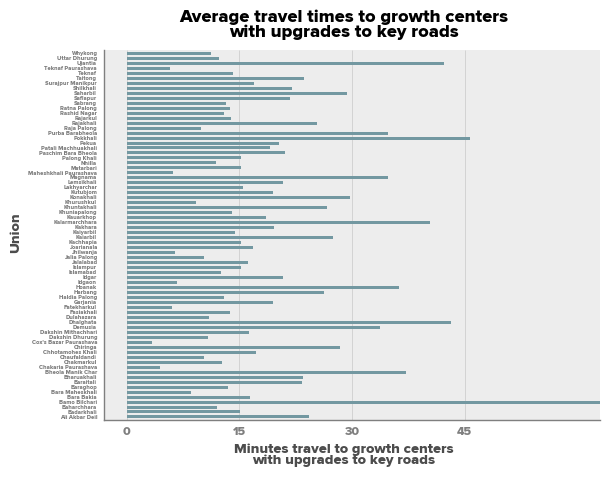

<ggplot: (-9223371857403127776)>

In [45]:
adm4_plot